In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
import random
import cv2

import keras

import keras_cv

import tensorflow as tf


In [3]:
sns.set_style('darkgrid')

In [4]:
base_dir = '/home/nima/dataset/Brain_Tumor'
os.listdir(base_dir)

['Training', 'Testing']

In [5]:
train_path = os.path.join(base_dir, 'Training')
test_path = os.path.join(base_dir, 'Testing')

In [6]:
classes = [class_name for class_name in os.listdir(train_path)]
classes

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

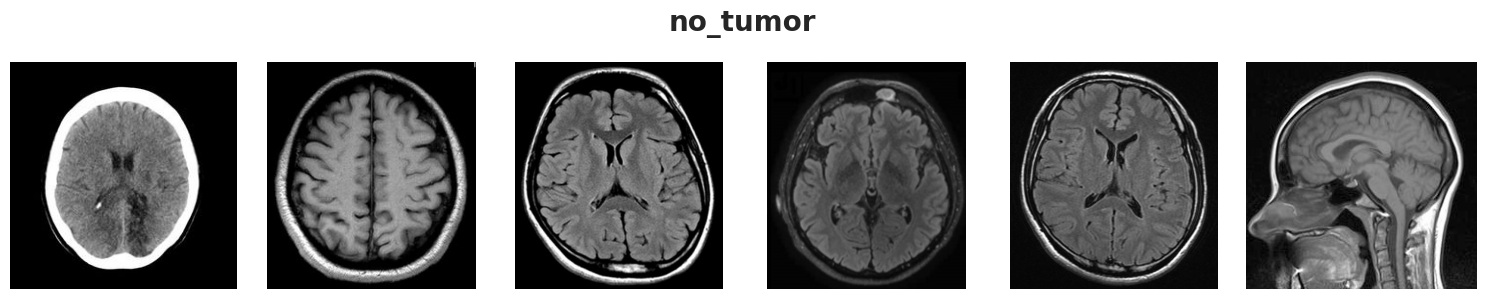

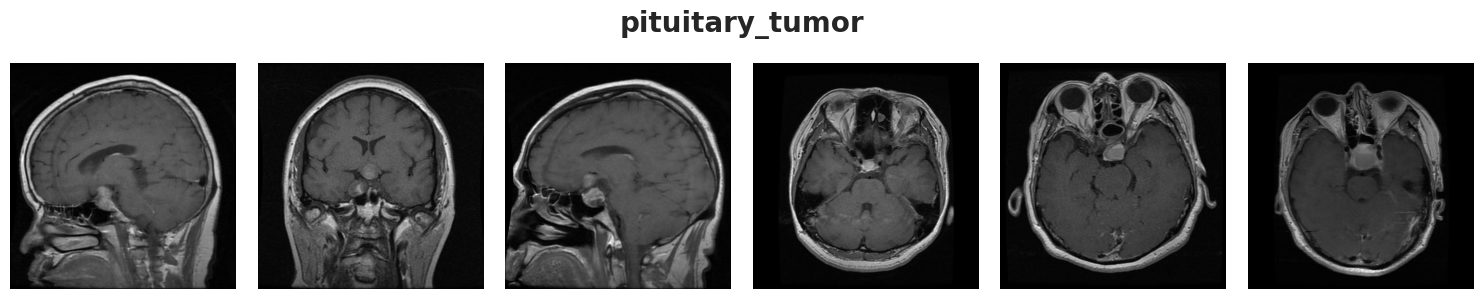

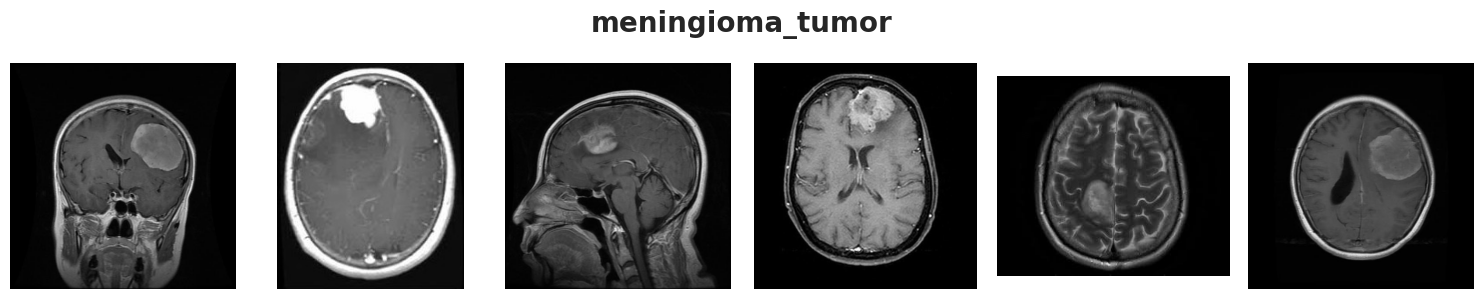

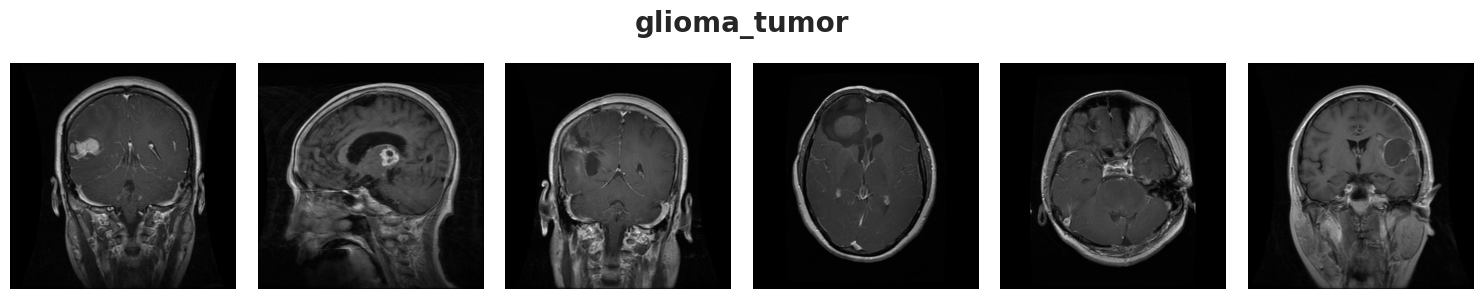

In [7]:
for class_name in classes :
    fig, ax = plt.subplots(1, 6, figsize=(15, 3))
    class_path = os.path.join(train_path, class_name)
    files = os.listdir(class_path)
    random_images = random.choices(files, k=6)
    for i in range(6) :
        plt.suptitle(class_name, fontsize=20, fontweight='bold')
        img = os.path.join(class_path ,random_images[i])
        img = keras.utils.load_img(img)
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()

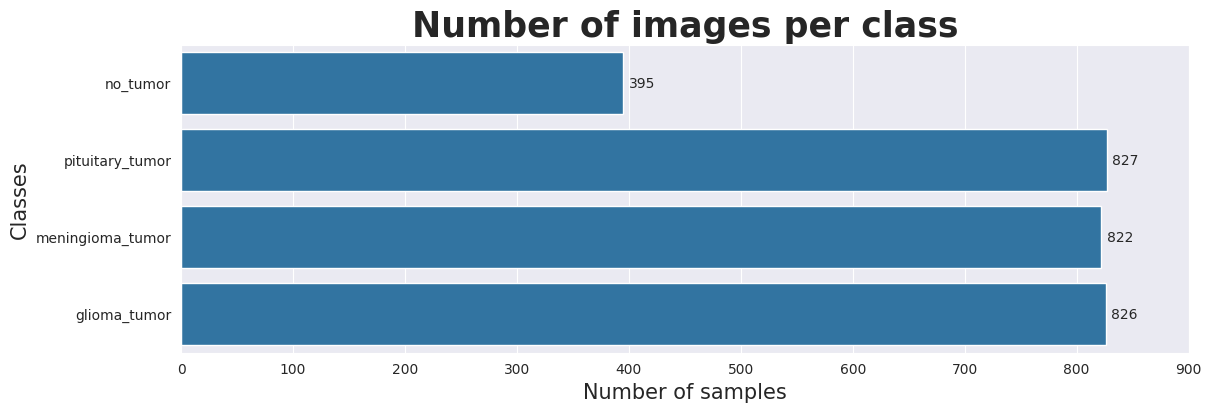

In [8]:
counts = []
for class_name in classes :
    class_path = os.path.join(train_path, class_name)
    counts.append(len(os.listdir(class_path)))


plt.figure(figsize=(13, 4))
ax = sns.barplot(y=classes, x=counts)
ax.set_xticks(range(0, 950, 100))
# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{}'.format(counts[i]),
            va="center", fontsize=10)
plt.title('Number of images per class', fontsize=25, fontweight='bold')
plt.ylabel('Classes', fontsize=15)
plt.xlabel('Number of samples', fontsize=15)
plt.show()

In [17]:
train_full = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    seed=42,
    batch_size=32,
    image_size=(224, 224)
 )

Found 2870 files belonging to 4 classes.


In [10]:
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    seed=42,
    batch_size=32,
    image_size=(224, 224)
)

Found 394 files belonging to 4 classes.


# Create train and validatin dataset from train_full

In [11]:
print(colored(f'number of train_full batches : {len(list(train_full))}', 'black', attrs=['bold']))

number of train_full batches : 90


In [12]:
train_full = train_full.shuffle(buffer_size=3)
train_ds = train_full.take(80)
valid_ds = train_full.skip(80)

In [13]:
print(colored(f'number of train batches : {len(list(train_ds))}', 'green', attrs=['bold']))
print(colored(f'number of valid batches : {len(list(valid_ds))}', 'green', attrs=['bold']))
print(colored(f'number of test  batches : {len(list(test_ds))}', 'green', attrs=['bold']))

number of train batches : 80
number of valid batches : 10
number of test  batches : 13


# augmentation

Base on article :
https://link.springer.com/article/10.1007/s10462-023-10453-z#:~:text=2.1%20Augmentation%20of%20brain%20MR,several%20tasks%20(Table%201).
there are several way to augmentate MRI images.


### RandomBrightness

A preprocessing layer which randomly adjusts brightness during training.

This layer will randomly increase/reduce the brightness for the input RGB images. At inference time, the output will be identical to the input. Call the layer with training=True to adjust the brightness of the input.

Note: This layer is safe to use inside a tf.data pipeline (independently of which backend you're using).

Arguments

factor: Float or a list/tuple of 2 floats between -1.0 and 1.0. The factor is used to determine the lower bound and upper bound of the brightness adjustment. A float value will be chosen randomly between the limits. When -1.0 is chosen, the output image will be black, and when 1.0 is chosen, the image will be fully white. When only one float is provided, eg, 0.2, then -0.2 will be used for lower bound and 0.2 will be used for upper bound.

In [15]:
# Averaging Blur
def blur(img) :
    """ Apply Averaging Blur to image """
    # return cv2.blur(img2,(10,10))
    kernel = np.ones((5,5),np.float32)/50
    return cv2.filter2D(img,-1,kernel)
   
 
# Gaussian Blurring 
def gausian_blur(img) :
    """ Apply Gaussian Blurring to image """
    return cv2.GaussianBlur(img, (9, 9), -0.5)  

# RandomBrightness
def RandomBrightness(img) :
    """ Change Brighness of image in a defined range """
    RB = keras_cv.layers.RandomBrightness(factor=(-0.25, 0.25))
    return RB(img, training=True)

# RandomAugmentation
def RandomAugmentation(img) :
    """ Apply random augmentations """
    rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=2,
    magnitude=0.5,
    magnitude_stddev=0.2,
    rate=0.2)
    return rand_augment(img)

# add_gaussian_noise
def add_gaussian_noise(image, mean=0, std=0.5):
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape)
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# downsample_upsample
def downsample_upsample(image, scale_percent=50):
    """ Downsample and then upsample an image """
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

In [16]:
def plot_augments(img) :
    fig, ax = plt.subplots(1, 7, figsize=(15, 4))
    ax[0].imshow(img)
    ax[0].set_title('Original')
    
    ax[1].imshow(blur(img))
    ax[1].set_title('Averaging_Blur')
    
    ax[2].imshow(gausian_blur(img))
    ax[2].set_title('Gausian_Blur')
    
    ax[3].imshow(RandomAugmentation(keras.utils.array_to_img(img)))
    ax[3].set_title('Rand_Augment')
    
    ax[4].imshow(RandomBrightness(keras.utils.array_to_img(img)))
    ax[4].set_title('Rand_Bright')
    
    ax[5].imshow(add_gaussian_noise(img))
    ax[5].set_title('gaussian_noise ')

    ax[6].imshow(downsample_upsample(img))
    ax[6].set_title('dow/up_sample ')
    
    for i in range(7) :
        ax[i].axis('off')

In [ ]:
img = cv2.imread('/home/nima/Downloads/cv.png')
plot_augments(img)

# Add augmentations to dataset

In [ ]:
img = os.path.join(class_path ,random_images[i])
img = keras.utils.load_img(img)
img = keras.utils.img_to_array(img)
# plot_augments(img)

In [ ]:
plt.imshow(img)

In [ ]:
gfdgfdgfdgd

In [ ]:
img2 = keras.utils.img_to_array(img)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(cv2.blur(img, (5, 5)))

In [ ]:
augs = ['Original', 'RandomBrightness', 'RandomAugmentation', 'add_gaussian_noise', 'apply_blur']


for row in range(5) :
    fig, ax = plt.subplots(1, 4, figsize=(13, 3))
    plt.suptitle(augs[row], fontsize=20, fontweight='bold')
    for i in range(4) :
        
        img = os.path.join(class_path ,random_images[i])
        img = keras.utils.load_img(img)
        img_array = keras.utils.img_to_array(img)
        #
        if augs[row] == 'Original' :
            ax[i].imshow(img)
        elif augs[row] == 'RandomBrightness' :
            ax[i].imshow(RandomBrightness(img))
        elif augs[row] == 'RandomAugmentation' :
            ax[i].imshow(RandomAugmentation(img))
        elif augs[row] == 'add_gaussian_noise' :
            ax[i].imshow(add_gaussian_noise(img_array))
        elif augs[row] == 'apply_blur' :
            ax[i].imshow(apply_blur(img_array))
        ax[i].axis('off')
    plt.tight_layout()
    

In [ ]:
base_model = keras.applications.ResNet50V2(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

In [ ]:
# Add custom layers on top of the base model
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)  # Dropout added to prevent overfitting
x = keras.layers.Dense(4, activation='softmax')(x)  # Output layer for multi-class classification

# Create the final model
model = keras.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, 
                    epochs=10,
                    validation_data=valid_ds,
                   )

In [ ]:
# create train_df with columns=['file_path', class]

In [ ]:
data = []
train_count = {}
for class_name in classes :
    class_path = os.path.join(train_ds, class_name)

    class_count = len(os.listdir(class_path))
    train_count[class_name]=class_count
    data.extend(
        [(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)]
    )
train_df = pd.DataFrame(data, columns=['file_path', 'label'])

print('Shape of Train DataFrame : ', train_df.shape)
print('-'*30)
for class_name, class_count in train_count.items() :
    print(class_name, ':', class_count)

In [ ]:
data = []
test_count = {}
for class_name in classes :
    class_path = os.path.join(test_ds, class_name)

    class_count = len(os.listdir(class_path))
    test_count[class_name]=class_count
    data.extend(
        [(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)]
    )
test_df = pd.DataFrame(data, columns=['file_path', 'label'])
print('Shape of Test DataFrame : ', test_df.shape)
print('-'*30)
for class_name, class_count in test_count.items() :
    print(class_name, ':', class_count)

In [ ]:
%who_ls

In [ ]:
# Freeup some space with deleting unused variables



In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_steps_per_epoch = train_df.shape[0]//BATCH_SIZE
train_steps_per_epoch

In [ ]:
num_classes = len(classes)
num_classes

In [ ]:
def preprocess_input(image, label) :
    resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True)
    
    image = tf.cast(image, tf.float32)
    
    return resizing(image), tf.one_hot(label, num_classes)

In [ ]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=4
)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # rotation_range=20,                           # Rotate images by up to 20 degrees
        # width_shift_range=0.10,                      # Shift images horizontally by up to 10% of their width
        # height_shift_range=0.10,                     # Shift images vertically by up to 10% of their height
        # zoom_range=0.10,                             # Zoom in/out by up to 10%
        # horizontal_flip=True,                        # Allow horizontal flipping
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=train_steps_per_epoch
)